<a href="https://colab.research.google.com/github/h0806449f/TensorFlow/blob/main/Tibame_TensorFlow_TF(cat_vs_dog).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

上游任務 vs 下游任務
1. 上游 : 擷取圖片特徵
2. 下游 : 分類
3. 上游可以移植他人已經訓練好的模型 
    針對分類的類別, 再加上我們的任務需求
4. 特徵擷取 仍然需要與我方任務有關聯

In [1]:
# source
# model zoo : https://modelzoo.co/

In [2]:
# imagenet
# https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

In [3]:
import zipfile
path = "/content/drive/MyDrive/Learn/Deep Learn/_train.zip"
f = zipfile.ZipFile(path)
f.extractall()

(-0.5, 499.5, 373.5, -0.5)

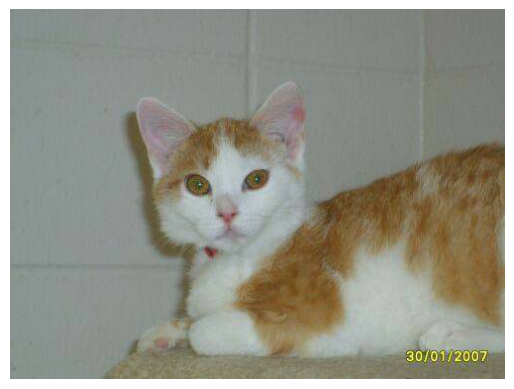

In [4]:
import glob
import matplotlib.pyplot as plt
from PIL import Image

fs = glob.glob("train/*")

plt.imshow(Image.open(fs[2000]))
plt.axis("off")

In [5]:
import random
import pandas as pd

dogs = glob.glob("train/dog.*")
random.shuffle(dogs)

cats = glob.glob("train/cat.*")
random.shuffle(cats)

# 僅取特定數量 -> cat 1000 dog 1000
# 直接將資料分成三份 -> train 900+900 / validate 50+50 / test 50+50
# 轉 DataFrame

train = pd.DataFrame({
    "filename":dogs[:900] + cats[:900],
    "class":["dog"] * 900 + ["cat"] * 900
})
validate = pd.DataFrame({
    "filename":dogs[900:950] + cats[900:950],
    "class":["dog"] * 50 + ["cat"] * 50
})
test = pd.DataFrame({
    "filename":dogs[950:1000] + cats[950:1000],
    "class":["dog"] * 50 + ["cat"] * 50
})

In [6]:
# check DataFrame
train

,filename,class
0,train/dog.6349.jpg,dog
1,train/dog.12040.jpg,dog
2,train/dog.8111.jpg,dog
3,train/dog.2227.jpg,dog
4,train/dog.4063.jpg,dog
...,...,...
1795,train/cat.4893.jpg,cat
1796,train/cat.242.jpg,cat
1797,train/cat.9838.jpg,cat
1798,train/cat.7359.jpg,cat


In [7]:
# Generator Function (產生器)
r = range(50000000)  # r 是一個range物件
it = r.__iter__()   # __it__() 將r轉換為 : 跌代器物件

# 可以使用 __next__() 將range中的資料取出來
# 有跌代器物件後, 可以使用 __next__() 返回序列中的下一個值
it.__next__()
it.__next__()
it.__next__()

# 使用跌代器的目的 : 用於處理大型資料集 or 無窮序列
# 如果一次生成所有資料 -> ram癱瘓
# 可以理解為 for in ...

2

In [8]:
# Generator Function - yield
# 產生器函式使用yield語句來產生值, 而不是使用return
def test_return():
    l = [60, 70, 80, 90]
    for n in l:
        return n ** 2

def test_yield():
    l = [60, 70, 80, 90]
    for n in l:
        yield n ** 2

print(test_return())

for n in test_yield():  # test_yield 僅是一個產生器
    print(n)

3600
3600
4900
6400
8100


In [9]:
# Generator 於本案中的運用 -> 將圖片集中的路徑資料, 一個一個回傳

In [10]:
# https://keras.io/api/applications/
# 遷移學習哪一種模型, 就必須要使用該模型的 資料預處理方式 !!!
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# train資料 數據增強: zoom:放大(1,2) shear:偏斜(0,2) 水平翻轉
# 數據增強, 原始資料及數量不變。
# 而是即時生成轉換後的影像進入模型
train_datagenerator = ImageDataGenerator(
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

# validate & test的資料 僅需做預處理
test_datagenerator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_from_directory & flow_from_dataframe
# flow_from_dataframe: 檔案路徑一定要叫 filename / 答案一定要叫 class
train_set = train_datagenerator.flow_from_dataframe(
    train,            # dataframe名稱
    ".",             # 目前位置
    target_size=(224, 224),   # 每一張圖片縮到(224, 224) (根據當初imagenet的訓練大小)
    batch_size=32,        # 一次訓練32張
    class_mode="sparse"      # 自動將 dog / cat 字串 轉為0 / 1
)

test_set = test_datagenerator.flow_from_dataframe(
    test,
    ".",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse"
)

validate_set = test_datagenerator.flow_from_dataframe(
    validate,
    ".",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse"
)

Found 1800 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


(32, 224, 224, 3)


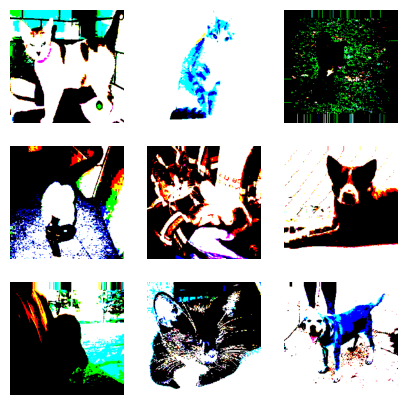

In [11]:
# 檢視 訓練資料被數據增強以後 的圖片
import matplotlib.pyplot as plt

# __next__ 會返回一個tuple (圖片, 答案)
batch = train_set.__next__()[0]  # 剛剛設定gererator一次會拿出32筆,這邊只取第1筆
print(batch.shape)   # (32, 224, 224, 3)

plt.figure(figsize=(5, 5))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch[i])
    plt.axis("off")

ImageNet的1000種分類  
https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

In [12]:
# 建立模型 - 特徵擷取
# 遷移學習 - VGG16
from tensorflow.keras.applications import VGG16

vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [13]:
# 建立模型 - 分類層
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization

# "不再"訓練特徵擷取層  (遷移學習的重點)
for layer in vgg.layers:
    layer.trainable = False

# 分類層
layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]

# 整合 layers
layers = vgg.layers + layers

# 
model = Sequential(layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [14]:
# compile
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(loss=SparseCategoricalCrossentropy(),
        optimizer="adam",
        metrics=["accuracy"])

In [15]:
# fit
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    ModelCheckpoint("TF_vgg16.h5", save_best_only=True),
    EarlyStopping(patience=10, restore_best_weights=True)
]

model.fit(train_set,
      epochs=150,
      validation_data=validate_set,
      callbacks=callbacks,
      verbose=2)

Epoch 1/150
57/57 - 46s - loss: 0.3999 - accuracy: 0.8428 - val_loss: 0.1473 - val_accuracy: 0.9600 - 46s/epoch - 799ms/step
Epoch 2/150
57/57 - 31s - loss: 0.2036 - accuracy: 0.9472 - val_loss: 0.0951 - val_accuracy: 0.9800 - 31s/epoch - 539ms/step
Epoch 3/150
57/57 - 28s - loss: 0.1596 - accuracy: 0.9550 - val_loss: 0.0755 - val_accuracy: 0.9700 - 28s/epoch - 491ms/step
Epoch 4/150
57/57 - 28s - loss: 0.1343 - accuracy: 0.9583 - val_loss: 0.0668 - val_accuracy: 0.9700 - 28s/epoch - 495ms/step
Epoch 5/150
57/57 - 28s - loss: 0.1107 - accuracy: 0.9656 - val_loss: 0.0597 - val_accuracy: 0.9700 - 28s/epoch - 489ms/step
Epoch 6/150
57/57 - 30s - loss: 0.1030 - accuracy: 0.9633 - val_loss: 0.0531 - val_accuracy: 0.9700 - 30s/epoch - 529ms/step
Epoch 7/150
57/57 - 28s - loss: 0.0979 - accuracy: 0.9639 - val_loss: 0.0486 - val_accuracy: 0.9800 - 28s/epoch - 496ms/step
Epoch 8/150
57/57 - 28s - loss: 0.0917 - accuracy: 0.9683 - val_loss: 0.0475 - val_accuracy: 0.9800 - 28s/epoch - 495ms/step


In [16]:
# evaluate
model.evaluate(x=test_set)

4/4 [==============================] - 1s 125ms/step - loss: 0.0348 - accuracy: 0.9900


[0.034780316054821014, 0.9900000095367432]

In [17]:
# predict
model.predict(test_set)

4/4 [==============================] - 1s 202ms/step


array([[3.10217467e-04, 9.99689817e-01],
       [9.67101455e-01, 3.28985229e-02],
       [1.18615603e-10, 1.00000000e+00],
       [5.92143647e-02, 9.40785587e-01],
       [9.99998569e-01, 1.41362909e-06],
       [1.03700168e-05, 9.99989629e-01],
       [9.99931812e-01, 6.82215541e-05],
       [1.17741805e-02, 9.88225818e-01],
       [3.81701648e-09, 1.00000000e+00],
       [2.51460016e-01, 7.48540044e-01],
       [9.99986410e-01, 1.35635773e-05],
       [9.80894864e-01, 1.91051140e-02],
       [1.58151286e-03, 9.98418450e-01],
       [6.49347663e-01, 3.50652307e-01],
       [1.31184186e-09, 1.00000000e+00],
       [9.85962570e-01, 1.40373753e-02],
       [1.25581005e-06, 9.99998689e-01],
       [3.07767380e-07, 9.99999642e-01],
       [9.99999404e-01, 5.80894550e-07],
       [1.41116753e-01, 8.58883262e-01],
       [9.99332130e-01, 6.67889020e-04],
       [1.90737266e-02, 9.80926275e-01],
       [1.28158581e-05, 9.99987125e-01],
       [9.97424841e-01, 2.57522124e-03],
       [2.106549

使用了 data generator  
如果想要檢視原圖, 需要自己一張一張把原圖拿出來

In [18]:
import numpy as np
def getdata(df):
    img_ori, img_preprocess, target = [], [], []
    for fn, c in zip(df["filename"], df["class"]):
        img = Image.open(fn).resize((224, 224)).convert("RGB")
        img_np = np.array(img)
        # original
        img_ori.append(img_np)
        img_np_pre = preprocess_input(img_np)
        # preprocess
        img_preprocess.append(img_np_pre)
        if c == "cat":
            target.append(0)
        else:
            target.append(1)
    return (np.array(img_ori), np.array(img_preprocess), np.array(target))
img_ori, x_test, y_test = getdata(test)
print(img_ori.shape)
print(x_test.shape)
print(y_test.shape)

(100, 224, 224, 3)
(100, 224, 224, 3)
(100,)


In [19]:
pre = model.predict(img_ori).argmax(axis=-1)
pre

4/4 [==============================] - 1s 136ms/step


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
np.nonzero(y_test != pre)

(array([19, 32, 75, 86]),)

[19 32 75 86]


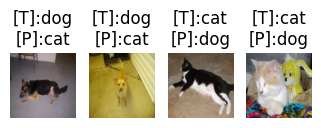

In [21]:
import numpy as np
trans = ["cat", "dog"]
idx = np.nonzero(y_test != pre)[0]
idx = idx[:100]
print(idx)
plt.figure(figsize=(10, 10))
# 預測錯誤的預測值
fp_pred = pre[idx]
# 預測錯誤的真實值
fp_true = y_test[idx]
# 預測錯誤的圖片
fp_img = img_ori[idx]
for i in range(len(idx)):
    plt.subplot(10, 10, i+1)
    plt.axis("off")
    t = "[T]:{}\n[P]:{}".format(trans[fp_true[i]], trans[fp_pred[i]])
    plt.title(t)
    plt.imshow(fp_img[i])

url:https://heho.com.tw/wp-content/uploads/2019/08/0812-%E8%B2%93%E5%92%AA_02.png
1/1 [==============================] - 1s 696ms/step
cat 的機率: 1.0
dog 的機率: 0.0


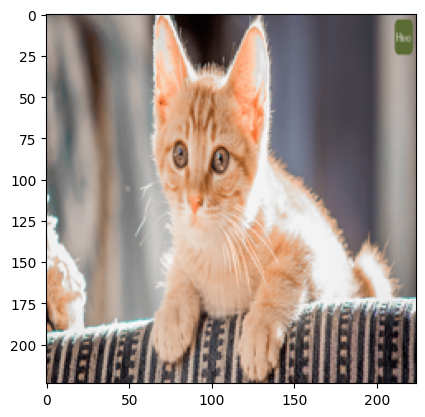

In [22]:
import requests
# pillow
from PIL import Image
url = input("url:")
response = requests.get(url, stream=True)
img = Image.open(response.raw).convert("RGB").resize((224, 224))
img_np = np.array(img).reshape(1, 224, 224, 3)
# (32, 32, 3) -> (1, 32, 32, 3)
img_np_pre = preprocess_input(img_np)
proba = model.predict(img_np_pre)[0]
for p, n in zip(proba, trans):
    print(n, "的機率:", round(p, 3))
plt.imshow(img)